![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [124]:
import warnings
warnings.filterwarnings('ignore')

In [221]:
# Importación de librerías
%matplotlib inline

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [126]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [127]:
#bikes.season.unique()
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.1 MB


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [128]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [129]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [130]:
#bikes.groupby('season').total.mean().describe()
bikes.groupby('hour').total.mean().describe()

count     24.000000
mean     190.742045
std      133.245822
min        6.407240
25%       70.979121
50%      211.895604
75%      256.828399
max      468.765351
Name: total, dtype: float64

In [131]:
bikes[(bikes['hour'] >= 5) & (bikes['hour'] <= 22)].shape[0] / bikes.shape[0]

0.7530773470512585

A partir de la primer consulta a los datos es posible observar que 
> - La estación en la que más se registra el uso de bicicletas es **verano** con un promedio de **234** bicicletas por hora, seguido por **primavera** con un promedio de **215** bicicletas por hora, seguido por **otoño** con un promedio de **198** bicicletas por hora, siendo así **invierno** la estación en la que registra la menor cantidad de usos del servicio de alquiler con un promedio de **116** bicicletas por hora, es decir, que en invierno la demanda del servicio se reduce a menos de la mitad que en verano.
> - Es importante notar que en promedio, el **25%** de los alquileres por temporada es de **178** bicicletas o menos y el **75%** de los alquileres por temporada es de **220** bicicletas o menos
> - Además, la desviación estándar se encuentra muy alejada de la media de alquiler de bicicletas entre enero de 2011 y diciembre de 2012, la cual es de 191 bicicletas por hora lo que sugiere que la estación es un factor bastante influyente en la demanda de este servicio de alquiler.

A partir de la segunda consulta, es posible observar que
> - La hora en la que se registra mayor demanda del servicio es las **5** de la tarde con un promedio de **468** bicicletas por hora y la hora de menor demanda es las **4 am** con un promedio de **6** bicicletas por hora.
> - El 25% de los alquileres por hora es de 70 bicicletas o menos y el 75% de los alquileres por hora es de 256 bicicletas o menos.  Ese **75%** de los alquileres se encuentra distribuido entre las **5 de la mañana y las 10 pm**.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

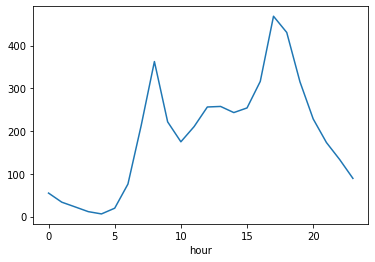

In [132]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

> A partir de la gráfica podemos deducir que la demanda de alquiler de bicicletas es bimodal, es decir, existe mayor demanda a las 8 am y las 5 pm

In [133]:
def plot_avg_per_hr_season(season):
    season_bikes = bikes[bikes["season"] == season]
    df_winter_avg = season_bikes.groupby("hour")["total"].mean().reset_index()

    fig = px.line(df_winter_avg, x="hour", y="total", title=f"Promedio de bicicletas alquiladas por hora en estación {season}")
    fig.update_xaxes(title="Hora del día")
    fig.update_yaxes(title="Promeido bicicletas alquiladas")
    fig.show()

In [134]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
plot_avg_per_hr_season(1)

> Puede notarse que la demanda en invierno tiene 2 picos, uno a las **8 am** y otro a las **5 pm** con **253 y 283 bicicletas en promedio por hora**.  Además la demanda se encuentra por debajo de **50** bicicletas en promedio por hora entre las **11 pm y las 6 am**.

In [135]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
plot_avg_per_hr_season(3)

> Puede notarse que la demanda en verano mantiene el mismo patrón de alquiler a lo largo del día con los mismos picos en la demanda a las 8 am y 5 pm.  También puede confirmarse lo mencionado en el primer punto acerca de que la demanda en verano es aproximadamente el doble de la demanda promedio que en invierno.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [136]:
# Celda 3

# Utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras
predictors = bikes[['season', 'hour']]
target = bikes['total']

# Teniendo en cuenta que la variable "season" es categórica. 
season_dummies = pd.get_dummies(predictors['season'], prefix='season', drop_first=True)
predictors = pd.concat([predictors.drop('season', axis=1), season_dummies], axis=1)

# Ajuste un modelo de regresión lineal a todo el conjunto de datos
model_1 = LinearRegression()
model_1.fit(predictors, target)

# Luego, imprima los coeficientes e interprételos.
print(f'Coeficientes: {model_1.coef_}')

Coeficientes: [ 10.54520609 100.31723192 119.46754995  84.08311787]


In [137]:
# Evaluar el desempeño del modelo de regresión lineal
y_pred = model_1.predict(predictors)

mse = mean_squared_error(target, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(target, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

MSE: 25480.69
RMSE: 159.63
R²: 0.22


> Los coeficientes obtenidos tras entrenar el modelo de regresión lineal indican que:
> - Por cada hora que transcurre en el día se espera que en promedio se renten 10 bicicletas más
> - Para primavera en promedio se espera que se alquilen 100 bicicletas más que en invierno
> - Para verano en promedio se espera que se alquilen 119 bicicletas más que en invierno
> - Para otoño en promedio se espera que se alquilen 84 bicicletas más que en invierno

> **¿Cuáles son las limitaciones de la regresión lineal en este caso?**
- Solo se seleccionaron 2 variables y se asume que la relación entre las variables es lineal, pero podría no ser así.  De hecho, a partir del análisis en el punto 2, puede verse que a lo largo del día la demanda no es constante puede aumentar o disminuir en ciertos periodos
- Otras variables podrían explicar mejor el fenómeno del alquiler.  Además aún faltaría evaluar los supuestos del modelo: homocedasticidad, no multicolinealidad y normalidad.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [196]:
# Funciones necesarias
final_nodes = []

# Definición de la función que calcula el gini index
def gini(y):
    return 0 if y.shape[0] == 0 else 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, conteo=0, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
       
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    
    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

def count_leaf_nodes(tree):
    if 'sl' not in tree and 'sr' not in tree:
        return 1
    else:
        left_count = count_leaf_nodes(tree['sl']) if 'sl' in tree else 0
        right_count = count_leaf_nodes(tree['sr']) if 'sr' in tree else 0
        return left_count + right_count

In [202]:
# Celda 4
# ...para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". 
predictors_2 = bikes[['season', 'hour']]
target_2 = bikes['total']

# El árbol debe tener al menos 6 nodos finales.
depth = 3
tree = tree_grow(predictors_2, target_2, level=0, min_gain=0.001, max_depth=depth, num_pct=10)

tree_predict(predictors_2, tree)

f'Con una profundidad de {depth} niveles, el árbol tiene {count_leaf_nodes(tree)} nodos finales'

'Con una profundidad de 3 niveles, el árbol tiene 96 nodos finales'

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

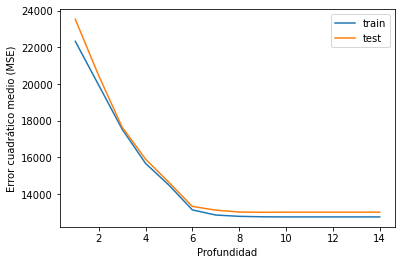

In [123]:
# Celda 5

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 15)
train_errors = []
test_errors = []

X_train, X_test, y_train, y_test = train_test_split(predictors_2, target_2, test_size=0.2, random_state=1)

# Evaluar el desempeño del modelo a medida que se hace más profundo
for depth in max_depth_range:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    tree.fit(X_train, y_train)
    train_errors.append(mean_squared_error(y_train, tree.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, tree.predict(X_test)))

plt.plot(max_depth_range, train_errors, label='train')
plt.plot(max_depth_range, test_errors, label='test')
plt.xlabel('Profundidad')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.show()

> Al graficar el error cuadrático medio obtenido a medida que el árbol se hacía más profundo podemos ver que con una profundiad de 6 ya no se obtiene una mejora considerable en la disminución del error que para esa profundidad es de 13000 aproximadamente.  Este valor resulta ser mucho menor que el obtenido con el modelo de regresión lineal, con el que obtuvimos un MSE de 25480.69

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [203]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            6000 non-null   object 
 1   timedelta                      6000 non-null   float64
 2   n_tokens_title                 6000 non-null   float64
 3   n_tokens_content               6000 non-null   float64
 4   n_unique_tokens                6000 non-null   float64
 5   n_non_stop_words               6000 non-null   float64
 6   n_non_stop_unique_tokens       6000 non-null   float64
 7   num_hrefs                      6000 non-null   float64
 8   num_self_hrefs                 6000 non-null   float64
 9   num_imgs                       6000 non-null   float64
 10  num_videos                     6000 non-null   float64
 11  average_token_length           6000 non-null   float64
 12  num_keywords                   6000 non-null   f

In [205]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [206]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [236]:
def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # evaluar el desempeño del modelo
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    oob_score = model.oob_score_ if hasattr(model, 'oob_score_') else 0
    print(f"{type(model).__name__} | Accuracy: {accuracy * 100:.2f}% | F1-Score: {f1 * 100:.2f}% | Out of bag score: {oob_score * 100:.2f}%")

In [237]:
# Celda 6
# Construya un árbol de decisión
tree_2 = DecisionTreeClassifier(max_depth=5, random_state=42)
eval_model(tree_2, X_train, y_train, X_test, y_test)

# Para el árbol calibre al menos un parámetro

# y una regresión logística
logistic_regression = LogisticRegression()
eval_model(logistic_regression, X_train, y_train, X_test, y_test)


DecisionTreeClassifier | Accuracy: 64.00% | F1-Score: 66.33% | Out of bag score: 0.00%
LogisticRegression | Accuracy: 61.20% | F1-Score: 60.83% | Out of bag score: 0.00%


> Puede observarse que el modelo de árbol de decisión presenta una mayor precisión en la predicción, es decir 64%, frente al 61% obtenido con la regresión logística

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [251]:
# Celda 7

# 100 árboles de decisión donde max_depth tome un valor de su elección
tree_by_max_depth = DecisionTreeClassifier(max_depth=5)
bagging_tree_by_max_depth = BaggingClassifier(base_estimator=tree_by_max_depth, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# 100 árboles de decisión donde min_samples_leaf tome un valor de su elección
tree_by_min_samples = DecisionTreeClassifier(min_samples_leaf=50)
bagging_tree_by_min_samples = BaggingClassifier(base_estimator=tree_by_min_samples, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# 100 regresiones logísticas
logreg = LogisticRegression()
bagging_logreg = BaggingClassifier(base_estimator=logreg, n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score
eval_model(bagging_tree_by_max_depth, X_train, y_train, X_test, y_test)
eval_model(bagging_tree_by_min_samples, X_train, y_train, X_test, y_test)
eval_model(bagging_logreg, X_train, y_train, X_test, y_test)

# Luego evalúe el ensamble de modelos y compare los resultados. 

BaggingClassifier | Accuracy: 65.73% | F1-Score: 65.73% | Out of bag score: 64.07%
BaggingClassifier | Accuracy: 67.20% | F1-Score: 67.11% | Out of bag score: 63.96%
BaggingClassifier | Accuracy: 61.80% | F1-Score: 61.31% | Out of bag score: 61.51%


> Luego de realizar varias iteraciones cambiando los parámetros `maxDepth` y `min_samples_leaf` desde 1 hasta 60, se encontró que a medida que se aumenta el valor, la precisión del modelo tiende a aumentar, sin embargo cuando esos parámetros tomas valores superiores a 50 el desempeño empieza a degradarse, por lo que para este modelo un buen desempeño se logra con `maxDepth` y `min_samples_leaf` = 50.  La deventaja de usar este valor como parámetro es la complejidad del árbol, por tener 50 niveles de complejidad.

> Al evaluar el out of bag puede notarse que cuando `maxDepth` y `min_samples_leaf` son igual a 5, se logra el máximo score out of bag, cual es de 64.07%, lo que sugiere que el modelo en ese punto ha "aprendido mejor" de los datos de entrenamiento y tiene una mayor capacidad para ajustarse a ellos siendo a su vez siendo un modelo no tan profundo.

> En cuanto al modelo de regressión lógistica, es el de peor desempeño de los 3.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [255]:
# Celda 8
models = [bagging_tree_by_max_depth, bagging_tree_by_min_samples, bagging_logreg]

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
for model in models:
    errors = np.zeros(model.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], model.n_estimators))

    for i in range(model.n_estimators):
        oob_sample = ~model.estimators_samples_[i]
        y_pred_ = model.estimators_[i].predict(X_train.values[oob_sample])
        errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, i] = model.estimators_[i].predict(X_test)
        
    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

    print(f1_score(y_pred, y_test), accuracy_score(y_pred, y_test))

0.6494915254237288 0.6553333333333333
0.6697798532354903 0.67
0.6121621621621622 0.6173333333333333


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9

> Creo que con votación ponderada debería mejorar el desempeño porque se supone que las debilidades de cada modelo de manera independiente son compensadas con las fortalezas de los otros modelos entre si.  No entiendo, creo que hice algo mal en el punto 8.